In [1]:
import time

%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

from collections import Counter
from itertools import groupby
from scipy import stats
from scipy.special import gammaln, xlogy

In [2]:
def IBP_stick_breaking(alpha, N, K):
    mu = np.random.beta(alpha,1,size=K)
    pi = np.cumprod(mu)
    return pi

def FTM_synthetic_data(M, K, Nvocab, gamma, alpha, eta, supervised=False, mu_a=0, sigma_a=1, sigma_y=1):

    phi = np.random.gamma(gamma,1, size=K)
    beta = np.random.dirichlet(eta, size=K)  # topic distribution over words

    pi = IBP_stick_breaking(alpha,M,K)
    b = np.random.binomial(n=1, p=pi, size=(M,K))
    # error for small m (since small m -> some obs have no active features)
    n = np.random.negative_binomial(b.dot(phi),0.5)
    theta = np.apply_along_axis(np.random.dirichlet, arr=b*phi, axis=1)

    zs,ws = [],[]
    for m in range(M):
        # draw topic for each word slot
        z = np.random.choice(range(K), p=theta[m,:], size=n[m])
        zs.append(z)
        # draw word for each word slot
        w = [np.random.choice(range(Nvocabulary), p=beta[z_word,:]) for z_word in z]
        ws.append(w)
    
    if supervised:
        n_per_mk = get_n_per_mk(zs,K)
        a = np.random.normal(mu_a, sigma_a, size=K)
        n_per_mk_norm = n_per_mk / n_per_mk.sum(axis=1)[:,np.newaxis]
        y = np.random.normal(n_per_mk_norm.dot(a), sigma_y)
        return phi, beta, pi, b, n, theta, zs, ws, y, a
    
    return phi, beta, pi, b, n, theta, zs, ws, None, None


def get_n_per_mk(z, K):
    # Nwords_per_doc_and_topic
    topic_counts_per_doc = [Counter(z_m) for z_m in z]
    n_per_mk = pd.DataFrame(topic_counts_per_doc, columns=range(K))
    n_per_mk = np.nan_to_num(n_per_mk)
    return n_per_mk


def get_n_per_ik(z, w, K, Nvocab):
    # Nvocabulary x K matrix to look up how often particular word associated with particular topic
    topic_word_pair_counts_per_doc = [Counter(zip(z_m,w_m)) for z_m,w_m in zip(z,w)]
    topic_word_pair_counts_per_doc = pd.DataFrame(topic_word_pair_counts_per_doc)
    topic_word_pair_counts_series = topic_word_pair_counts_per_doc.sum(axis=0)
    k,i = zip(*topic_word_pair_counts_series.index)
    # topic_word_pair_counts
    n_per_ik = np.zeros((Nvocab,K))
    n_per_ik[i,k] = topic_word_pair_counts_series.values
    return n_per_ik

In [16]:
M_dgp = 100  # number of documents
K_trunc = 100 # truncation level for number of topics 
gamma = 3  # some approximations used in the inference below rely on gamma not being large (cf ICD appendix)
alpha = 3
Nvocabulary = 50
eta = np.ones(Nvocabulary)/Nvocabulary
supervised = True
mu_a = 0
sigma_a = 1
sigma_y = 1

phi_dgp, beta, pi_dgp, b_dgp, n_dgp, theta, z_dgp, w_dgp, y_dgp, a_dgp = FTM_synthetic_data(M_dgp, K_trunc, Nvocabulary, gamma, alpha, eta, supervised, mu_a, sigma_a, sigma_y)
n_dgp

array([17, 10, 21, 14, 12, 16,  6,  7,  8, 27, 15,  9,  9, 15,  6,  6,  1,
       18, 14,  5, 15, 12, 11, 24, 19, 10,  7, 21,  8,  9,  8, 21, 16,  5,
       10,  8, 22, 11,  2, 20, 21,  7,  8, 10,  3, 14, 13,  2,  8, 11, 10,
       10,  1,  5, 11, 13,  2, 16, 17, 13, 14,  9, 11,  5, 12,  6, 27, 13,
       12,  8, 13, 20, 15,  9, 15, 11,  9,  2, 13, 12,  6,  7,  6,  6, 16,
        5,  8, 12,  3, 20,  7,  8, 12, 16,  8, 20, 16,  6, 20,  7])

-0.161327251062


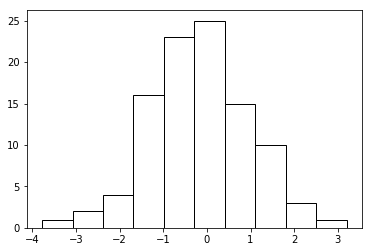

In [17]:
print y_dgp.mean()
plt.hist(y_dgp, edgecolor='k', color='white');

In [18]:
n_per_mk_dgp = get_n_per_mk(z_dgp,K_trunc)
print n_per_mk_dgp.shape
# check correctness by summing counts over all topics
(n_per_mk_dgp.sum(axis=1)-n_dgp).sum()

(100L, 100L)


0.0

In [19]:
n_per_ik_dgp = get_n_per_ik(z_dgp, w_dgp, K_trunc, Nvocabulary)
print n_per_ik_dgp.shape
n_per_ik_dgp.sum() - n_dgp.sum() # should be 0

(50L, 100L)


0.0

In [20]:
# not all words in vocabulary will have been used
words_used = [w for w_m in w_dgp for w in w_m]
len(set(words_used)), (n_per_ik_dgp.sum(axis=1)==0).sum()

(38, 12)

(0, 24L)

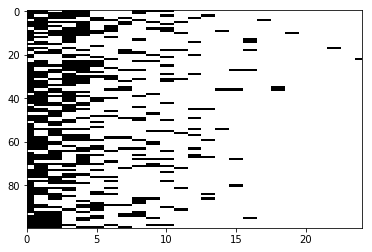

In [21]:
Kmax = n_per_mk_dgp[:,~np.all(n_per_mk_dgp==0, axis=0)].shape[1]

plt.imshow(b_dgp, cmap='Greys', aspect='auto');
plt.xlim(0,Kmax)

In [22]:
def f_case1(U, nm_excl_i):
    return ((2.**U)*(nm_excl_i+U))**-1


def d2f_case1(U, nm_excl_i):
    return 2.**(1-U)/(nm_excl_i+U)**3 + (2**-U)*np.log(2)**2/(nm_excl_i+U) + 2**(1-U)*np.log(2)/(nm_excl_i+U)**2


def f_case3(X, Ystar, Ydagger, nm_excl_i):
    return Ydagger / ( 2.**(X+Ystar+Ydagger) * (nm_excl_i+X+Ystar+Ydagger) )


def d2f_dYstar2_case3(X, Ystar, Ydagger, nm_excl_i):
    U = X+Ystar+Ydagger
    return Ydagger*d2f_case1(U, nm_excl_i)


def d2f_dYdagger2_case3(X, Ystar, Ydagger, nm_excl_i):
    U = X+Ystar+Ydagger
    return ( Ydagger*2.**(1-U) / (nm_excl_i+U)**3
            + (Ydagger*(2**-U)*np.log(2)**2 - np.log(2)*2**(1-U)) / (nm_excl_i+U) 
            - 2*(2**-U - Ydagger*np.log(2)*2**-U) / (nm_excl_i+U)**2 )


# vectorized over k, returns vector with p_zmi for k=0,...,K-1
def logp_zmi_us(eta_wmi, nwmi_kexcli, n_per_mk_excli, m, i, z, phi, pi, alpha, gamma):
    return np.log(nwmi_kexcli+eta_wmi) + np.log(E_g_X_Y(n_per_mk_excli, m, i, z, phi, pi, alpha, gamma))


def logp_zmi_s(eta_wmi, nwmi_kexcli, n_per_mk_excli, m, i, z, phi, pi, alpha, gamma, y_m, a, sigma_y):
    K = len(phi)
    X_m = n_per_mk_excli[m,:] + np.eye(K)  # vectorizes over k (1st row ^= zij=0 -> add 1 to count for 1st topic, 2nd row: add 1 to count for 2nd topic)
    return np.log(nwmi_kexcli+eta_wmi) + np.log(E_g_X_Y(n_per_mk_excli, m, i, z, phi, pi, alpha, gamma)) + logp_y_m(y_m, X_m, a, sigma_y)


def logp_y_m(y_m, X_m, a, sigma_y):
    return -1./(2*sigma_y**2)*(y_m-X_m.dot(a))**2


# vectorized over k, returns vector with p_zmi for k=0,...,K-1 (only case 1,2 depend on k)
def E_g_X_Y(n_per_mk_excl_i, m, i, z, phi, pi, alpha, gamma):
          
    X = phi[n_per_mk_excl_i[m,:]>0].sum()
    Jstar_m = (n_per_mk_excl_i[m,:]==0) & (n_per_mk_excl_i.sum(axis=0)>0)
    EYstar = np.sum(pi[Jstar_m]*phi[Jstar_m])
    VYstar = np.sum(pi[Jstar_m]*(1-pi[Jstar_m])*phi[Jstar_m]**2)
    EYdagger = alpha * gamma
    VYdagger = alpha*gamma*(gamma+1) - (alpha*gamma)**2/(2*alpha+1.)
    EY = EYstar + EYdagger
    VY = VYstar + VYdagger
    
    mask1 = (n_per_mk_excl_i[m,:] > 0)
    #case1 = (n_per_mk_excl_i[m,:]+phi) * (f_case1(X+EY,n_per_mk_excl_i[m,:].sum()) + 0.5*d2f_case1(X+EY,n_per_mk_excl_i[m,:].sum())*VY)  # vector
    case1 = (f_case1(X+EY,n_per_mk_excl_i[m,:].sum()) + 0.5*d2f_case1(X+EY,n_per_mk_excl_i[m,:].sum())*VY)  # vector
    mask2 = ~mask1 & (n_per_mk_excl_i.sum(axis=0) > 0)
    EY_excl_k = EY - pi*phi  # vector
    VY_excl_k = VY - pi*(1-pi)*phi**2  # vector
    #case2 = phi*pi * (f_case1(X+EY_excl_k+phi,n_per_mk_excl_i[m,:]) + 0.5*d2f_case1(X+EY_excl_k+phi,n_per_mk_excl_i[m,:])*VY_excl_k)  # vector
    case2 = (f_case1(X+EY_excl_k+phi,n_per_mk_excl_i[m,:]) + 0.5*d2f_case1(X+EY_excl_k+phi,n_per_mk_excl_i[m,:])*VY_excl_k)  # vector
    mask3 = ~mask1 & ~mask2
    case3 = (f_case3(X,EYstar,EYdagger,n_per_mk_excl_i[m,:].sum()) 
                + 0.5*d2f_dYstar2_case3(X,EYstar,EYdagger,n_per_mk_excl_i[m,:].sum())*VYstar 
                + 0.5*d2f_dYdagger2_case3(X,EYstar,EYdagger,n_per_mk_excl_i[m,:].sum())*VYdagger )
    return mask1*case1 + mask2*case2 + mask3*case3


def draw_via_PIT(logpdf,args,lb,ub,Npoints):
    # calc pdf for region of interest & normalize -> distribution for region of interest
    points = np.linspace(lb,ub,Npoints)
    logpdf_approx = logpdf(points,*args)
    logpdf_approx = logpdf_approx - logpdf_approx.max()
    logc = sp.special.logsumexp(logpdf_approx)  # normalizing constant, sp.integrate.quad(p_new_pi,0,1,args=(alpha_sample,N))
    logpdf_approx_norm = logpdf_approx - logc
    cdf_approx = np.cumsum(np.exp(logpdf_approx_norm))
    cdf_approx_unique, idx = np.unique(cdf_approx, return_index=True)
    points_unique = points[idx]
    
    unif = np.random.uniform(0,1)
    sample = np.interp(unif, cdf_approx_unique, points_unique) # PIT via inverse interpolation
    
    # uniform random jitter centered at 0 & width equal to stepsize (cf BDA p76)
    stepsize = (ub-ub)/float(Npoints)
    sample = sample + np.random.uniform(-stepsize/2.,stepsize/2.)
    
    return sample #,cdf_approx_unique, points_unique


def logp_new_pi(pi, alpha, N):
    Ns = np.array(range(1,N+1))
    if isinstance(pi, np.ndarray):    
        Ns = Ns[:,np.newaxis]
    logp_pi = xlogy(alpha-1,pi) + xlogy(N,1-pi) + alpha*np.sum(1./Ns*(1-pi)**Ns,axis=0)
    return logp_pi


def logp_phi_n(n_per_mk, b, gamma, phi):
    logp = ( xlogy(gamma-1,phi) - phi - gammaln(gamma) 
            + np.sum(b * (gammaln(phi+n_per_mk) - gammaln(phi) - gammaln(n_per_mk+1) - (phi+n_per_mk)*np.log(2)), axis=0) )
    return np.log(phi>0) + logp


def p_b(b, pi, phi, nm_k):
    mask1 = nm_k>0
    mask2 = (b==0) & (nm_k==0)
    mask3 = (b==1) & (nm_k==0)
    p0 = pi
    p1 = 2**phi*(1-pi)
    return mask1*b + mask2*p1/(p0+p1) + mask3*p0/(p0+p1)

In [23]:
def sICD_collapsed_gibbs(iters, w, Nvocab, alpha, gamma, z0, phi0, pi0, b0, supervised=False, y=None, a0=None, 
                         mu_a=0, sigma_a=1, sigma_y=1, iters_MH=100, sigma_proposal=1, Npoints=1000):
    
    z, phi, pi, b, a = z0, phi0, pi0, b0, a0
    
    M,K = b.shape
    n_per_mk = get_n_per_mk(z, K)
    n_per_ik  = get_n_per_ik(z, w, K, Nvocab)
    n = np.array([len(w_m) for w_m in w])
    
    # only keep active features
    activefeatures = (n_per_mk.sum(axis=0) != 0)
    n_per_mk = n_per_mk[:,activefeatures]
    n_per_ik = n_per_ik[:,activefeatures]
    phi = phi[activefeatures]
    pi = pi[activefeatures]
    b = b[:,activefeatures]
    if supervised:
        a = a[activefeatures]
    K_plus = len(pi)
    # adjust z since dropping inactive features leads to rearrangement (e.g. droping feature 2 -> feature 3 becomes feature 2)
    old2new_index = {old_idx:new_idx for old_idx,(status,new_idx) in enumerate(zip(activefeatures,np.cumsum(activefeatures)-1)) if status}
    z = [np.array([old2new_index[k] for k in z_m]) for z_m in z]

    pis, phis, bs, zs, Ks, a_samples, y_hats = [],[],[],[],[],[],[]
    loglikelihoods, acceptance_ratios, runtime = [],[],[]

    start_time = time.time()

    for t in range(iters):
        # update pi (semi-ordered slice sampler)
        # draw s conditonal on pi,B
        # stick_length of last active feature (pi_sorted_acrtive sorted by decreasing pi -> last element is min)
        pi_star = min(1,sorted(pi,reverse=True)[-1])
        s = np.random.uniform(0,pi_star)
        # until pi_(K°+1)<s: generate inactive features & draw pi, let K° be # of features generated
        pi_new = []
        pi_ball = s+1 # just sth >s
        pi_kmin1 = pi_star  # ?what is correct first value
        while pi_ball >= s: 
            # draw new pi
            pi_ball = draw_via_PIT(logpdf=logp_new_pi, args=[alpha,M], lb=0,ub=pi_kmin1, Npoints=Npoints)
            pi_new.append(pi_ball)
            pi_kmin1 = pi_ball
        pi_new = pi_new[:-1]  # exclude pi_(K°+1) 
        pi = np.append(pi, pi_new)
        K_ball = len(pi_new)
        K = K_plus+K_ball

        # update phi
        accepted = 0
        phi_samples = []
        # for active features
        for i in range(iters_MH):
            lposterior_old = logp_phi_n(n_per_mk, b, gamma, phi)
            phi_proposal = np.random.normal(loc=phi, scale=sigma_proposal, size=K_plus)
            lposterior_proposal = logp_phi_n(n_per_mk, b, gamma, phi_proposal)
            logr = lposterior_proposal - lposterior_old
            mask = np.log(np.random.uniform(size=K_plus)) < logr
            phi[mask] = phi_proposal[mask]
            accepted += mask.sum()
            phi_samples.append(phi.copy())
        phi_posterior_mean = np.mean(phi_samples[iters_MH//2:],axis=0)
        # for inactive features (logp_phi_n simplifies to Gamma(gamma,1) prior)
        phi_new = np.random.gamma(gamma,1, size=K_ball)

        phi = np.append(phi_posterior_mean, phi_new)
        acceptance_ratios.append(accepted/float(iters_MH*K_plus))

        n_per_mk = np.concatenate((n_per_mk, np.zeros((M,K_ball))),axis=1)
        n_per_ik = np.concatenate((n_per_ik, np.zeros((Nvocabulary,K_ball))),axis=1)
        if supervised:
            a = np.append(a, np.random.normal(mu_a, sigma_a, size=K_ball))

        # update b
        p_bmk = p_b(np.ones((M,K_plus+K_ball)), pi, phi, n_per_mk)
        b = np.random.binomial(1,p_bmk)

        # update z_mi
        for m in range(M):
            for i in range(n[m]):
                wmi = w[m][i]
                # exclude current assignment of word from counts
                k_old = z[m][i]
                n_per_mk[m, k_old] -= 1
                n_per_ik[wmi, k_old] -= 1
                # get probability for all possible new assignments
                if supervised:
                    logp_zmi = logp_zmi_s(eta[wmi], n_per_ik[wmi,:], n_per_mk, m, i, z, phi, pi, alpha, gamma, y[m], a, sigma_y)
                else:
                    logp_zmi = logp_zmi_us(eta[wmi], n_per_ik[wmi,:], n_per_mk, m, i, z, phi, pi, alpha, gamma)
                logp_zmi = logp_zmi - logp_zmi.max()
                logp_zmi_norm = logp_zmi - sp.special.logsumexp(logp_zmi)
                k_new = np.random.choice(range(K),p=np.exp(logp_zmi_norm))
                z[m][i] = k_new
                n_per_mk[m, k_new] += 1
                n_per_ik[wmi, k_new] += 1

        # only keep active features
        activefeatures = (n_per_mk.sum(axis=0) != 0)
        n_per_mk = n_per_mk[:,activefeatures]
        n_per_ik = n_per_ik[:,activefeatures]
        phi = phi[activefeatures]
        pi = pi[activefeatures]
        b = b[:,activefeatures]
        if supervised:
            a = a[activefeatures]
        K_plus = len(pi)
        K = K_plus
        # adjust z since dropping inactive features leads to rearrangement (e.g. droping feature 2 -> feature 3 becomes feature 2)
        old2new_index = {old_idx:new_idx for old_idx,(status,new_idx) in enumerate(zip(activefeatures,np.cumsum(activefeatures)-1)) if status}
        z = [np.array([old2new_index[k] for k in z_m]) for z_m in z]

        # update a
        if supervised:
            X = n_per_mk / n_per_mk.sum(axis=1)[:,np.newaxis]
            a_postvar = np.linalg.pinv(X.T.dot(X)+np.eye(K)*sigma_a**2)
            a_postmean = a_postvar.dot(X.T).dot(y)
            a = np.random.multivariate_normal(a_postmean, a_postvar)
            y_hat = X.dot(a)

        runtime.append(time.time()-start_time)
        beta_postmean_unnorm = n_per_ik+eta[:,np.newaxis]
        beta_postmean = beta_postmean_unnorm / beta_postmean_unnorm.sum(axis=0)
        loglikelihood = np.sum(stats.multinomial.logpmf(n_per_ik.T, n=n_per_ik.sum(axis=0), p=beta_postmean.T))
        loglikelihoods.append(loglikelihood)
        bs.append(b.copy())
        # ?easier way to copy the whole list including sublists (I tried: list(z), import copy, copy.copy(z), z as list of list instead of list of arrays)
        zs.append([z_m.copy() for z_m in z])
        phis.append(phi.copy())
        pis.append(pi.copy())
        Ks.append(K)
        if supervised:
            a_samples.append(a.copy())
            y_hats.append(y_hat.copy())
            
    logs = {'iteration':range(1,iters+1), 'runtime':runtime, 'loglikelihood':loglikelihoods, 'acceptance_ratio':acceptance_ratios}
    samples = {'K':Ks, 'z':zs, 'b':bs, 'phi':phis, 'pi':pis}
    if supervised:
        samples['a'] = a_samples
        samples['y_hat'] = y_hats
    
    return samples, logs

In [ ]:
# initialize with data generating parameters
iters = 50
samples,logs = sICD_collapsed_gibbs(iters, w_dgp, Nvocabulary, alpha, gamma, z_dgp, phi_dgp, pi_dgp, b_dgp, supervised=True, y=y_dgp, a0=a_dgp, 
                         mu_a=mu_a, sigma_a=sigma_a, sigma_y=sigma_y)

In [108]:
# train-test split
percentage_test = 0.5
testindices = np.random.choice(range(M_dgp), size=int(M_dgp*percentage_test), replace=False)

w_dict = {'all':w_dgp, 'test':[w_dgp[idx] for idx in testindices], 'train':np.delete(w_dgp,testindices, axis=0)}
b_dict = {'all':b_dgp, 'test':b_dgp[testindices,:], 'train':np.delete(b_dgp,testindices, axis=0)}
if supervised:
    y_dict = {'all':y_dgp, 'test':y_dgp[testindices], 'train':np.delete(y_dgp,testindices, axis=0)}

In [109]:
#%%time
# settings
iters = 100
Npoints = 1000  # number of points for approximating CDF for slice sampler
iters_MH = 100
sigma_proposal = 1  # for MH
supervised = True

# train
dataset = 'train' #'train', 'test', 'all'
w = w_dict[dataset]
M = len(w)
if supervised:
    y = y_dict[dataset]

# initialization
K = Kmax
z = [np.random.choice(range(K),size=len(w_m)) for w_m in w]  # list(z_dgp)
phi = np.random.gamma(gamma,1, size=K)
pi = IBP_stick_breaking(alpha,M,K)
b = np.random.binomial(n=1, p=pi, size=(M,K))
a = np.random.normal(mu_a, sigma_a, size=K)

samples_train,logs_train = sICD_collapsed_gibbs(iters, w, Nvocabulary, alpha, gamma, z, phi, pi, b, supervised=supervised, y=y, a0=a, 
                         mu_a=mu_a, sigma_a=sigma_a, sigma_y=sigma_y, iters_MH=iters_MH, sigma_proposal=sigma_proposal)

C:\Program Files\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:99: RuntimeWarning: divide by zero encountered in log
C:\Program Files\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:59: RuntimeWarning: invalid value encountered in less


In [110]:
# test
dataset = 'test' #'train', 'test', 'all'
w = w_dict[dataset]
M = len(w)
if supervised:
    y = y_dict[dataset]

K = Kmax
z = [np.random.choice(range(K),size=len(w_m)) for w_m in w]  # list(z_dgp)
phi = np.random.gamma(gamma,1, size=K)
pi = IBP_stick_breaking(alpha,M,K)
b = np.random.binomial(n=1, p=pi, size=(M,K))

samples_test,logs_test = sICD_collapsed_gibbs(iters, w, Nvocabulary, alpha, gamma, z, phi, pi, b, supervised=False, 
                                              iters_MH=iters_MH, sigma_proposal=sigma_proposal)

C:\Program Files\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:99: RuntimeWarning: divide by zero encountered in log
C:\Program Files\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:59: RuntimeWarning: invalid value encountered in less


In [111]:
settings = 'iters='+str(iters)+',M='+str(M_dgp)+',Nvocab='+str(Nvocabulary)+',gamma='+str(gamma)+',alpha='+str(alpha)+',supervised='+str(supervised)
if supervised:
    settings += ',mu_a='+str(mu_a)+',sigma_a='+str(sigma_a)+',sigma_y='+str(sigma_y)
    
fileending = settings+'_8'

In [112]:
samples = {'test':samples_test, 'train':samples_train}
logs = {'test':logs_test, 'train':logs_train}

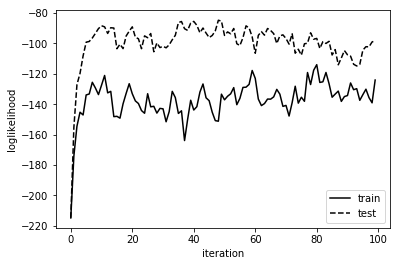

In [113]:
plt.plot(logs_train['loglikelihood'], 'k', label='train')
plt.plot(logs_test['loglikelihood'], '--k', label='test')
#plt.plot(loglikelihoods, '--k')
plt.xlabel('iteration')
plt.ylabel('loglikelihood');
plt.legend();
plt.savefig('figures/loglikelihood_'+fileending+'.png', bbox_inches='tight')

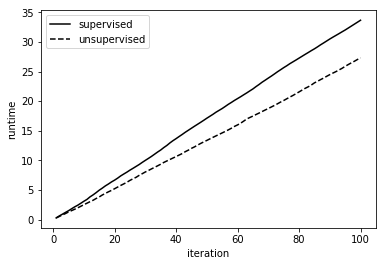

In [114]:
plt.plot(logs_train['iteration'], logs_train['runtime'], 'k', label='supervised')
plt.plot(logs_test['iteration'], logs_test['runtime'], '--k', label='unsupervised')
plt.ylabel('runtime')
plt.xlabel('iteration');
plt.legend();
plt.savefig('figures/runtime_'+fileending+'.png', bbox_inches='tight')

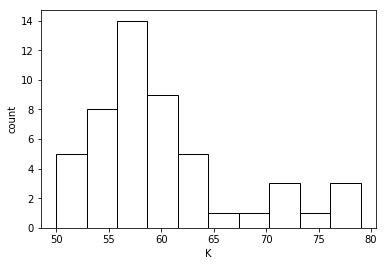

In [115]:
dataset = 'train'

K_mode = np.bincount(samples[dataset]['K'][iters//2:]).argmax()
#print K_mode, np.mean(samples[dataset]['K'][iters/2:])

plt.hist(samples[dataset]['K'][iters//2:], edgecolor='k', color='white');
plt.xlabel('K')
plt.ylabel('count');
plt.savefig('figures/histK_'+fileending+'_'+dataset+'.png', bbox_inches='tight')

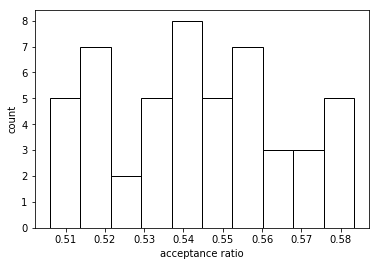

In [116]:
#print np.mean(logs[dataset]['acceptance_ratio'][iters/2:])
plt.hist(logs[dataset]['acceptance_ratio'][iters//2:], edgecolor='k', color='white');
plt.xlabel('acceptance ratio')
plt.ylabel('count')
plt.savefig('figures/histAcceptanceRatio_'+fileending+'_'+dataset+'.png', bbox_inches='tight')

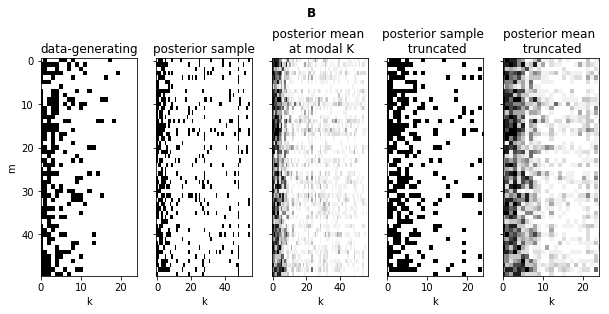

In [117]:
fig,[ax1,ax2,ax3,ax4,ax5] = plt.subplots(1,5, sharey=True, figsize=[10,4])
fig.suptitle(r'$\mathbf{B}$',y=1.06)

ax1.imshow(b_dict[dataset], cmap='Greys', aspect='auto');
ax1.set_xlim(0,Kmax)
ax1.set_xlabel('k')
ax1.set_ylabel('m')
ax1.set_title(r'data-generating')

b_K_mode = [b for b in samples[dataset]['b'][iters//2:] if b.shape[1]==K_mode]
ax2.imshow(b_K_mode[-1], cmap='Greys', aspect='auto');
ax2.set_xlabel('k')
ax2.set_title('posterior sample')

ax3.imshow(np.mean(b_K_mode,axis=0), cmap='Greys', aspect='auto');
ax3.set_xlabel('k');
ax3.set_title('posterior mean \n at modal K');

ax4.imshow(b_K_mode[-1], cmap='Greys', aspect='auto');
ax4.set_xlim(0,Kmax)
ax4.set_xlabel('k')
ax4.set_title('posterior sample \n truncated')

ax5.imshow(np.mean(b_K_mode,axis=0), cmap='Greys', aspect='auto');
ax5.set_xlim(0,Kmax)
ax5.set_xlabel('k');
ax5.set_title('posterior mean \n truncated');

plt.savefig('figures/b_'+fileending+'_'+dataset+'.png', bbox_inches='tight')

In [118]:
def R2(yhat,y):
    # <0 means yhat fits worse than sample  mean y.mean()
    return 1 - np.sum((yhat-y)**2) / np.sum((y-y.mean())**2)

In [123]:
# sICD
# train
y_train_sICD = samples['train']['y_hat'][iters//2:]
# test
K2a_dict_sICD = {K: np.mean(list(a),axis=0) for K,a in groupby(samples['train']['a'][iters//2:], key=lambda a: len(a))}
y_test_sICD = [(get_n_per_mk(z,K)/get_n_per_mk(z,K).sum(axis=1)[:,np.newaxis]).dot(K2a_dict_sICD[K]) for z,K in zip(samples['test']['z'],samples['test']['K']) if K in K2a_dict_sICD]

# 2-step
# train
y_train_2step, a_2step = [],[]
for z,K in zip(samples['train']['z'],samples['train']['K']):
    n_per_mk = get_n_per_mk(z,K)
    X = np.nan_to_num(n_per_mk / n_per_mk.sum(axis=1)[:,np.newaxis])
    a_postvar = np.linalg.pinv(X.T.dot(X)+np.eye(K)*sigma_a**2)
    a_postmean = a_postvar.dot(X.T).dot(y_dict['train'])
    a = np.random.multivariate_normal(a_postmean, a_postvar)
    y_train_2step.append(X.dot(a))
    a_2step.append(a)
# test    
K2a_dict_2step = {K: np.mean(list(a),axis=0) for K,a in groupby(a_2step[iters//2:], key=lambda a: len(a))}
y_test_2step = [get_n_per_mk(z,K).dot(K2a_dict_2step[K]) for z,K in zip(samples['test']['z'],samples['test']['K']) if K in K2a_dict_2step]

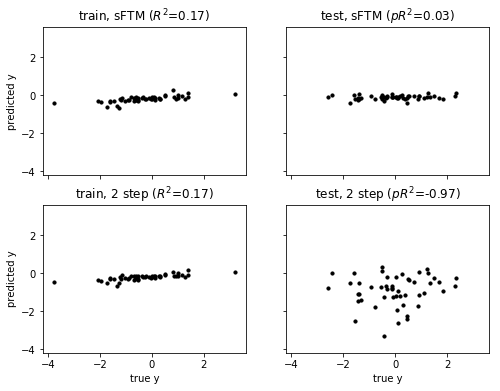

In [125]:
fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=[8,6])
axes_col1, axes_col2 = axes.T

for ax,y,method in zip(axes_col1,[y_train_sICD,y_train_2step],['sFTM','2 step']):
    R2_ = R2(np.mean(y,axis=0),y_dict['train'])
    #MSE = np.mean((np.mean(y,axis=0)-y_dict['train'])**2)
    ax.set_title('train, '+method+r' ($R^2$='+str(round(R2_,2))+')')
    ax.scatter(y_dict['train'],np.mean(y,axis=0), color='k', s=10)
    #ax.hist(np.mean(y,axis=0), normed=True, alpha=0.5, label='predicted response');
    #ax.hist(y_dict['train'], normed=True, alpha=0.5, label='true response');
    ax.set_ylabel('predicted y')
    ax.set_ylim(ax.get_xlim())
    
for ax,y,method in zip(axes_col2,[y_test_sICD,y_test_2step],['sFTM','2 step']):
    pR2 = R2(np.mean(y,axis=0),y_dict['test'])
    #MSE = np.mean((np.mean(y,axis=0)-y_dict['test'])**2)
    ax.set_title('test, '+method+r' ($pR^2$='+str(round(pR2,2))+')')
    ax.scatter(y_dict['test'],np.mean(y,axis=0), color='k', s=10)
    #ax.hist(np.mean(y,axis=0), normed=True, alpha=0.5, label='predicted response');
    #ax.hist(y_dict['test'], normed=True, alpha=0.5, label='true response');

axes_col1[-1].set_xlabel('true y')
axes_col2[-1].set_xlabel('true y');

plt.savefig('figures/Y_predictedVStrue'+fileending+'.png', bbox_inches='tight')

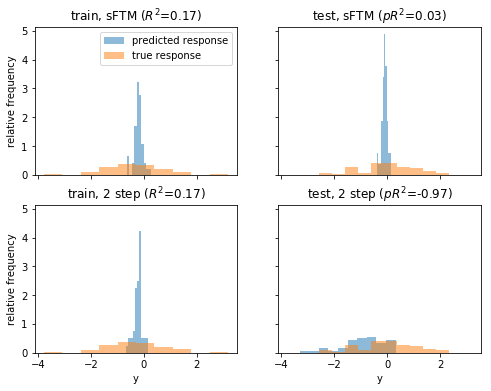

In [126]:
fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=[8,6])
axes_col1, axes_col2 = axes.T

for ax,y,method in zip(axes_col1,[y_train_sICD,y_train_2step],['sFTM','2 step']):
    R2_ = R2(np.mean(y,axis=0),y_dict['train'])
    #MSE = np.mean((np.mean(y,axis=0)-y_dict['train'])**2)
    ax.set_title('train, '+method+r' ($R^2$='+str(round(R2_,2))+')')
    ax.hist(np.mean(y,axis=0), normed=True, alpha=0.5, label='predicted response');
    ax.hist(y_dict['train'], normed=True, alpha=0.5, label='true response');
    ax.set_ylabel('relative frequency')
    
for ax,y,method in zip(axes_col2,[y_test_sICD,y_test_2step],['sFTM','2 step']):
    pR2 = R2(np.mean(y,axis=0),y_dict['test'])
    #MSE = np.mean((np.mean(y,axis=0)-y_dict['test'])**2)
    ax.set_title('test, '+method+r' ($pR^2$='+str(round(pR2,2))+')')
    ax.hist(np.mean(y,axis=0), normed=True, alpha=0.5, label='predicted response');
    ax.hist(y_dict['test'], normed=True, alpha=0.5, label='true response');

axes_col1[0].legend();
axes_col1[-1].set_xlabel('y')
axes_col2[-1].set_xlabel('y');

plt.savefig('figures/histY_'+fileending+'.png', bbox_inches='tight')